# MAPSI semaine 5 : Ind√©pendances conditionnelles et r√©seaux bay√©siens



## Exercice : Ind√©pendances conditionnelles et r√©seaux bay√©siens
Dans ce TME, l'objectif est d'apprendre des r√©seaux bay√©siens √† partir de bases de donn√©es. Hormis la base asia, un exemple jouet relativement petit qui vous permettra de mettre au point les diff√©rents algorithmes du TME, et car, les autres bases correspondront √† des distributions de probabilit√© de tailles raisonnables : 

|  nom de la base  |            provenance           | nombre d'evenements elementaires |
|:----------------:|:-------------------------------:|:--------------------------------:|
|       asia       |          BN repository          |                $256     $          |
|       alarm      |          BN repository          |              $10^{16}   $               |
|       adult      | UCI machine learning repository |              $10^{12}   $          |
|        car       | UCI machine learning repository |               $6912     $          |
| agaricus-lepiota | UCI machine learning repository |              $10^{16}   $        |


Apprendre un r√©seau bay√©sien consiste √† apprendre sa structure graphique ainsi que les param√®tres de ses distributions de probabilit√© conditionnelles. Pour r√©aliser la deuxi√®me t√¢che, il suffit d'estimer les param√®tres de chaque distribution conditionnelle par maximum de vraisemblance, comme vous l'avez fait dans le TME 3. Ici, nous nous focaliserons donc plut√¥t sur l'apprentissage de structure. Celle-ci refl√©tant des ind√©pendances conditionnelles entre variables al√©atoires, vous devrez exploiter des tests d'ind√©pendance du œá2 afin d'obtenir des structures graphiques les moins denses possibles (en termes de nombres d'arcs). Ainsi, alarm repr√©sente une distribution jointe de plus de 1016 √©v√©nements √©l√©mentaires mais, quand cette distribution est d√©compos√©e gr√¢ce au graphe ci-dessous (les noeuds repr√©sentant les variables al√©atoires), elle peut √™tre d√©crite (sans perte d'informations) √† l'aide de seulement 752 param√®tres. Comme nous l'avons vu en cours, cette repr√©sentation permet √©galement d'effectuer tr√®s rapidement des calculs probabilistes.

![Image ](tme5_alarm.png)

### 1. Lecture des donn√©es

Dans le code ci-dessous, la fonction `read_csv : string -> (string np.array, int np.2D-array, dico{string -> int} np.array)` vous permettra de lire les donn√©es des bases sur lesquelles vous allez travailler, et de les organiser sous une forme ad√©quate. Par exemple, une base de donn√©es est un fichier de la forme : 

```
 X_0,X_1,X_2,X_3
 haut,gauche,petit,bas
 bas,droite,grand,gauche
 bas,gauche,moyen,bas
```


Dans cette base, nous avons 4 variables al√©atoires nomm√©es X_0, X_1, X_2, et X_3, et 3 enregistrements qui repr√©sentent des instanciations (observ√©es) de ces 4 variables. Ainsi, X_0 a pour valeurs haut, bas et bas, X_1 a pour valeurs gauche, droite, gauche, etc.

La fonction `read_csv` prend en argument le nom d'un fichier CSV contenant une base de donn√©es et renvoie un triplet compos√© de :



- 1 tableau numpy de strings contenant les noms des variables al√©atoires. Par exemple, pour la base ci-dessus, ce tableau correspond √†: 
```python
 n.array (['X_0', 'X_1', 'X_2', 'X_3'])
```

- un tableau numpy 2D contenant les donn√©es du fichier CSV encod√©es sous forme num√©rique (les valeurs des variables al√©atoires sont transform√©es en nombres entiers): chaque ligne de ce tableau repr√©sente les intanciations d'une variable al√©atoire et chaque colonne repr√©sente un enregistrement de la base de donn√©es, c'est-√†-dire une instanciation/observation de toutes les variables al√©atoires. Pour la base ci-dessus, nous obtiendrions le tableau ci-dessous (la signification des nombres est indiqu√©e dans le dictionnaire pr√©cis√© plus bas): 
```python
 np.array ( [ [0, 1, 1],   # instanciations de la variable X_0
              [0, 1, 0],    # instanciations de la variable X_1
              [0, 1, 2],    # instanciations de la variable X_2
              [0, 1, 0]] )  # instanciations de la variable X_3
```

Ainsi, les valeurs observ√©es de la premi√®re variable al√©atoire X_0 correspondent √† la premi√®re ligne du tableau (0, 1 et 1). La premi√®re colonne correspond √† une observation de toutes les variables (X_0=0,X_1=0,X_2=0,X_3=0). C'est essentiellement sur ce tableau numpy que vous travaillerez dans ce TME. 


- un tableau numpy de dictionnaires faisant la correspondance, pour chaque variable al√©atoire, entre l'encodage num√©rique du tableau 2D ci-dessus et les donn√©es du fichier CSV (le 1er dictionnaire correspond √† la variable de la 1√®re colonne du CSV, le 2√®me dictionnaire √† celle de la 2√®me colonne, etc.). Ainsi, le dictionnaire est √©gal √† : 

```python
np.array( [ {'haut': 0, 'bas': 1},                  # encodage variable X_0
             {'gauche': 0, 'droite': 1},            # encodage variable X_1
             {'petit': 0, 'grand': 1, 'moyen': 2 }, # encodage variable X_2
             {'bas': 0, 'gauche': 1} ] )            # encodage variable X_3
```



On peut ainsi reconstituer le CSV d'origine. Par exemple, la premi√®re colonne du tableau 2D ci-dessus, qui est √©gale √† 0,0,0,0 correspond √† haut,gauche,petit,bas: "haut" correspondant au 0 de la premi√®re variable al√©atoire, "gauche" correspondant au 0 de la 2√®me variable, etc. 

Lisez-le fichier [tme5_asia.csv](tme5_asia.csv) √† l'aide de la fonction read_csv ci-dessous: la derni√®re instruction, `names, data, dico = read_csv ( "tme5_asia.csv" )`, vous permettra de r√©cup√©rer, s√©par√©ment, les trois champs du triplet renvoy√© par la fonction read_csv. 

In [1]:
# -*- coding: utf-8 -*-

import numpy as np

# fonction pour transformer les donn√©es brutes en nombres de 0 √† n-1
def translate_data ( data ):
    # cr√©ation des structures de donn√©es √† retourner
    nb_variables = data.shape[0]
    nb_observations = data.shape[1] - 1 # - nom variable
    res_data = np.zeros ( (nb_variables, nb_observations ), int )
    res_dico = np.empty ( nb_variables, dtype=object )

    # pour chaque variable, faire la traduction
    for i in range ( nb_variables ):
        res_dico[i] = {}
        index = 0
        for j in range ( 1, nb_observations + 1 ):
            # si l'observation n'existe pas dans le dictionnaire, la rajouter
            if data[i,j] not in res_dico[i]:
                res_dico[i].update ( { data[i,j] : index } )
                index += 1
            # rajouter la traduction dans le tableau de donn√©es √† retourner
            res_data[i,j-1] = res_dico[i][data[i,j]]
    return ( res_data, res_dico )


# fonction pour lire les donn√©es de la base d'apprentissage
def read_csv ( filename ):
    data = np.loadtxt ( filename, delimiter=',', dtype=str ).T
    names = data[:,0].copy ()
    data, dico = translate_data ( data )
    return names, data, dico

# names : tableau contenant les noms des variables al√©atoires
# data  : tableau 2D contenant les instanciations des variables al√©atoires
# dico  : tableau de dictionnaires contenant la correspondance (valeur de variable -> nombre)

names, data, dico = read_csv ( "tme5_asia.csv" )
print(names)
print(data)
print(dico)

['visit_to_Asia?' 'smoking?' 'tuberculosis?' 'lung_cancer?' 'bronchitis?'
 'tuberculos_or_cancer?' 'dyspnoea?' 'positive_XraY?']
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 1 ... 1 0 0]
 [0 1 1 ... 1 1 1]]
[{'true': 0, 'false': 1} {'false': 0, 'true': 1} {'true': 0, 'false': 1}
 {'false': 0, 'true': 1} {'false': 0, 'true': 1} {'false': 0, 'true': 1}
 {'false': 0, 'true': 1} {'false': 0, 'true': 1}]


### 2.  Statistique du $\chi^2$ conditionnel


Soit deux variables al√©atoires $X$ et $Y$. Appelons $N_{xy}$, $N_x$ et $N_y$, respectivement, le nombre d'occurrences du couple $(X=x,Y=y)$ et des singletons $X=x$ et $Y=y$ dans la base de donn√©es. Alors, comme indiqu√© dans le cours 5, la statistique du $\chi^2$ de $X$ et $Y$ est √©gale √† : 


$$\chi^2_{X,Y} = \sum_x\sum_y\frac{\left(N_{xy} - \frac{N_x \times N_y}{N}\right)^2}{\frac{N_x \times N_y}{N}}$$

o√π {$N$} repr√©sente le nombre de lignes de la base de donn√©es. Cette formule permet de tester l'ind√©pendance entre les deux variables {$X$} et {$Y$}. On peut ais√©ment g√©n√©raliser celle-ci pour tester des ind√©pendances conditionnellement √† un ensemble de variables {$\mathbf{Z}$}:

$$\chi^2_{X,Y|\mathbf{Z}} = \sum_x\sum_y\sum_{\mathbf{z}}\frac{\left(N_{xy\mathbf{z}} - \frac{N_{x\mathbf{z}} \times N_{y\mathbf{z}}}{N_{\mathbf{z}}}\right)^2}{\frac{N_{x\mathbf{z}} \times N_{y\mathbf{z}}}{N_{\mathbf{z}}}}$$

o√π $N_{xy\mathbf{z}}$, $N_{x\mathbf{z}}$, $N_{y\mathbf{z}}$ et $N_{\mathbf{z}}$ repr√©sentent, respectivement, le nombre d'occurrences du triplet $(X=x,Y=y,\mathbf{Z} = \mathbf{z})$, des couples $(X=x,\mathbf{Z} = \mathbf{z})$ et $(Y=y,\mathbf{Z} = \mathbf{z})$, et du singleton $\mathbf{Z} = \mathbf{z}$. Ainsi, si $\mathbf{Z}$ est un ensemble de 3 variables al√©atoires $(A,B,C)$, les valeurs $\mathbf{z}$ seront des triplets $(a,b,c)$.

Afin de vous aider √† calculer ces $\chi^2$, vous pourrez utiliser la fonction **create_contingency_table** `: int np.2D-array x dico{string -> int} np.array x int x int x int list -> (int, np.2D-array) np.array` ci-dessous. Celle-ci prend en argument le tableau 2D numpy `data` et le tableau de dictionnaires `dico` retourn√©s √† la fin de la question 1, ainsi que l'index `x` d'une variable al√©atoire (0 = 1√®re variable al√©atoire (celle de la 1√®re ligne de `data`), 1 = 2√®me variable, _etc._), l'index `y` d'une autre variable et une liste `z` d'index d'autres variables al√©atoires. Elle renvoie un tableau de couples ({$N_{\mathbf{z}}, T_{X,Y,\mathbf{z}})$}, pour tous les {$\mathbf{z} \in\mathbf{Z}$}, o√π:

*   $N_{\mathbf{z}}$ repr√©sente le nombre d'occurences de {$Z=z$} dans la base de donn√©es. Par exemple, si la base de donn√©es est la suivante :

```
 X_0,X_1,X_2,X_3
 haut,gauche,petit,bas
 bas,droite,grand,gauche
 bas,gauche,moyen,bas
```

nous avons vu plus haut que le tableau data est √©gal √† : 

```python
data = np.array ( [ [0, 1, 1],    # instanciations de la variable X_0
                     [0, 1, 0],    # instanciations de la variable X_1
                     [0, 1, 2],    # instanciations de la variable X_2
                     [0, 1, 0]] )  # instanciations de la variable X_3
```


L'application de **create_contingency_table ( data, dico, 0, 2, [3] )** renverra le tableau: 
```python
resultat = array([ (2, array([[ 1.,  0.,  0.],        # Z = 0 => N_{Z=0} = 2
                               [ 0.,  0.,  1.]])),
                    (1, array([[ 0.,  0.,  0.],        # Z = 1 => N_{Z=1} = 1
                               [ 0.,  1.,  0.]])) ])
```


C'est a dire : 
Si $X_3=0$

|       	| $X_2$=0| $X_2$=1 	| $X_2$=3 	|
|:-------:	|:-------:	|:-------:	|:-------:	|
| $X_0$=0 	|          1 	| 0 	| 0 	|
| $X_0$=1 	|          0 	| 0 	| 1 	|

Si $X_3=1$

|  	        | $X_2$=0   | $X_2$=1 	| $X_2$=3 	|
|:-------:	|:-------:	|:-------:	|:-------:	|
| $X_0$=0 	|   0 	    | 0 	    | 0 	    |
| $X_0$=1 	|   0 	    | 1 	    | 0 	    |



En effet le param√®tre `[3]` indique que $\mathbf{Z}$ est constitu√© uniquement de la quatri√®me variable de la base, autrement dit $X_3$. La derni√®re ligne du tableau `data` indique les instanciations de X_3 et l'on peut observer que la valeur 0 appara√Æt 2 fois et la valeur 1 appara√Æt une fois. On a donc $N_{Z=0} = 2$ et $N_{Z=1} = 1$. On peut observer que les valeurs de $N_{\mathbf{Z}}$ sont bien les premiers √©l√©ments des couples de `resultat`. Lorsque $\mathbf{Z} = \emptyset$, `resultat` est un tableau avec un seul couple dont le premier √©l√©ment correspond pr√©cis√©ment √† $N$, le nombre d'enregistrements de la base de donn√©es.

*  $T_{X,Y,\mathbf{z}}$ est un tableau 2D contenant le nombre d'occurrences $N_{xy\mathbf{z}}$ des couples $(X=x,Y=y)$ lorsque $\mathbf{Z}=\mathbf{z}$. La premi√®re dimension de ce tableau (les lignes) correspondent aux diff√©rentes valeurs de $X$ et la deuxi√®me (les colonnes) √† celles de {$Y$}. Ainsi, le tableau en haut √† droite de `resultat` est obtenu de la mani√®re suivante: ce tableau correspond √† des occurrences de $(X,Y)$ lorsque $\mathbf{Z}=0$. on commence donc par extraire de `data` le sous-tableau correspondant √† la premi√®re et √† la troisi√®me colonne (les colonnes o√π X_3=0) et on ne retient que les lignes correspondant √† X_0 et X_2 (cf. les param√®tres 0 et 2 pass√©s en arguments de **create_contingency_table**). On obtient donc le sous-tableau:

```python
np.array ( [ [0, 1],    # instanciations de la variable X_0
              [0, 2]] )  # instanciations de la variable X_2
```

Ce tableau nous indique que, lorsque $X_3=0$, les couples $(X_0=0,X_2=0)$ et $(X_0=1,X_2=2)$ apparaissent une seule fois et ce sont les seuls couples qui apparaissent dans la base de donn√©es. C'est pr√©cis√©ment ce que repr√©sente le tableau en haut √† droite de `resultat`

In [2]:
# etant donn√© une BD data et son dictionnaire, cette fonction cr√©e le
# tableau de contingence de (x,y) | z

def create_contingency_table ( data, dico, x, y, z ):
    # d√©termination de la taille de z
    size_z = 1
    offset_z = np.zeros ( len ( z ) )
    j = 0
    for i in z:
        offset_z[j] = size_z      
        size_z *= len ( dico[i] )
        j += 1

    # cr√©ation du tableau de contingence
    res = np.zeros ( size_z, dtype = object )

    # remplissage du tableau de contingence
    if size_z != 1:
        z_values = np.apply_along_axis ( lambda val_z : val_z.dot ( offset_z ),
                                         1, data[z,:].T )
        i = 0
        while i < size_z:
            indices, = np.where ( z_values == i )
            a,b,c = np.histogram2d ( data[x,indices], data[y,indices],
                                     bins = [ len ( dico[x] ), len (dico[y] ) ] )
            res[i] = ( indices.size, a )
            i += 1
    else:
        a,b,c = np.histogram2d ( data[x,:], data[y,:],
                                 bins = [ len ( dico[x] ), len (dico[y] ) ] )
        res[0] = ( data.shape[1], a )
    return res


In [3]:
resultat=create_contingency_table ( data, dico, 0, 2, [3,4] ) 
print(resultat)


[(66, array([[ 0.,  0.],
        [ 0., 66.]]))    (844, array([[817.,  14.],
                                [ 13.,   0.]]))
 (37, array([[ 0., 36.],
        [ 0.,  1.]]))    (1053, array([[1.025e+03, 1.200e+01],
                                [1.500e+01, 1.000e+00]]))     ]



En utilisant la structure retourn√©e par la fonction **create_contingency_table**, √©crivez une fonction **sufficient_statistics**`: int np.2D-array x dico{string -> int} np.array x int x int x int list -> float` qui prend les m√™mes arguments que la fonction **create_contingency_table** et qui renvoie la valeur de $\chi^2_{X,Y|\mathbf{Z}}$. Vous pourrez tirer profit du fait que $N_{x\mathbf{z}} = \sum_{y} N_{xy\mathbf{z}}$ et $N_{y\mathbf{z}} = \sum_{x} N_{xy\mathbf{z}}$, ce qui revient √† faire des sommes sur chaque ligne ou chaque colonne des tableaux $T_{X,Y,\mathbf{z}}$. 

**Attention :** il peut arriver que certains $N_{\mathbf{z}}$ soient √©gaux √† 0\. Dans ce cas, vous ne tiendrez pas compte des $N_{xy\mathbf{z}}$, $N_{x\mathbf{z}}$ et $N_{y\mathbf{z}}$ correspondants dans la formule de $\chi^2_{X,Y|\mathbf{Z}}$ (car vous feriez des divisions par 0, ce qui est mal).


Z = z
|          | $Y$=y_0           | $Y$=y_1           | $Y$=y_2           | $\Sigma$    |
|----------|-------------------|-------------------|-------------------|-------------|
| $X$=x_0  | $N_{x_0, y_0, z}$ | $N_{x_0, y_1, z}$ | $N_{x_0, y_2, z}$ | $N_{x_0,z}$ |
| $X$=x_1  | $N_{x_1, y_0, z}$ | $N_{x_1, y_1, z}$ | $N_{x_1, y_2, z}$ | $N_{x_1,z}$ |
| $\Sigma$ | $N_{y_0,z}$       | $N_{y_1,z}$       | $N_{y_2,z}$       | $N_z$       |


In [4]:
def sufficient_statistics ( data, dico, x, y, z ):
    # cr√©ation du tableau de contingence
    table = create_contingency_table ( data, dico, x, y, z )
    # print(table)
    nb_z = table.shape[0]
    nb_x, nb_y = table[0][1].shape
    s = []
    for N_z, T in table:

        N_xz = T.sum(axis=1) # Voir tableau si dessus
        N_yz = T.sum(axis=0) # Voir tableau si dessus
        if N_z==0: N_z=1
        frac = np.outer(N_xz,N_yz)/N_z # Outer √† cause de la double somme
        den = np.where(frac==0, 1, frac) # On √©vite la div pas z√©ros

        s.append((T - frac)**2/den)
        # display(f"num : {(T - frac)**2}")
        # display(f"frac: {frac}")
    s = np.array(s)
    return s.sum()


Vous pourrez v√©rifier la validit√© de vos calculs: en utilisant la base de donn√©es "2015_tme5_asia.csv", vous devriez obtenir les r√©sultats suivants :


| appel de la fonction 	| r√©sultat 	|
|--------------------------------------------------	|--------------------	|
| sufficient_statistics ( data, dico, 1,2,[3]) 	    | 3.9466591186668296 	|
| sufficient_statistics ( data, dico, 0,1,[2,3]) 	| 16.355207462350094 	|
| sufficient_statistics ( data, dico, 1,3,[2]) 	    | 81.807449348140295 	|
| sufficient_statistics ( data, dico, 5,2,[1,3,6]) 	| 1897.0 	|
| sufficient_statistics ( data, dico, 0,7,[4,5]) 	| 3.2223237760949699 	|
| sufficient_statistics ( data, dico, 2,3,[5]) 	    | 130.0 	|

In [5]:
display(sufficient_statistics( data, dico, 1,2,[3]))
display(sufficient_statistics( data, dico, 0,1,[2,3]))
display(sufficient_statistics( data, dico, 1,3,[2]))
display(sufficient_statistics( data, dico, 5,2,[1,3,6]))
display(sufficient_statistics( data, dico, 0,7,[4,5]))
display(sufficient_statistics( data, dico, 2,3,[5]))

3.946659118666829

16.355207462350094

81.8074493481403

1897.0

3.2223237760949703

130.00000000000003

## 3. Statistique du $\chi^2$ et degr√© de libert√©

Modifiez votre fonction **sufficient_statistics** afin qu'elle ne renvoie plus seulement $\chi^2_{X,Y|\mathbf{Z}}$ mais plut√¥t un couple ($\chi^2_{X,Y|\mathbf{Z}}$,DoF), o√π DoF est le nombre de degr√©s de libert√© de votre statistique. Celui-ci est √©gal √† :

$$(|X|-1) \times (|Y|-1) \times |\{\mathbf{z} : N_{\mathbf{z}} \neq 0\}| $$

o√π $|X|$ repr√©sente le nombre de valeurs possibles que peut prendre la variable $X$, autrement dit, c'est la taille de son dictionnaire. Le dernier terme de l'√©quation est simplement le nombre de $N_{\mathbf{z}}$ diff√©rents de 0.

Vous pourrez v√©rifier la validit√© de vos calculs: en utilisant la base de donn√©es "2015_tme5_asia.csv", vous devriez obtenir les r√©sultats suivants:

| appel de la fonction 	| r√©sultat 	|
|:------------------------------------------------:	|:-----------------------:	|
| sufficient_statistics ( data, dico, 1,2,[3]) 	| (3.9466591186668296, 2) 	|
| sufficient_statistics ( data, dico, 0,1,[2,3]) 	| (16.355207462350094, 3) 	|
| sufficient_statistics ( data, dico, 1,3,[2]) 	| (81.807449348140295, 2) 	|
| sufficient_statistics ( data, dico, 5,2,[1,3,6]) 	| (1897.0, 8) 	|
| sufficient_statistics ( data, dico, 0,7,[4,5]) 	| (3.2223237760949699, 4) 	|
| sufficient_statistics ( data, dico, 2,3,[5]) 	| (130.0, 2) 	|

In [6]:
def sufficient_statistics ( data, dico, x, y, z ):
    # cr√©ation du tableau de contingence
    table = create_contingency_table ( data, dico, x, y, z )
    # print(table)
    nb_z = table.shape[0]
    nb_x, nb_y = table[0][1].shape

    s = []
    for N_z, T in table:
        N_xz = T.sum(axis=1) # Voir tableau si dessus
        N_yz = T.sum(axis=0) # Voir tableau si dessus
        if N_z==0: 
            N_z=1
            nb_z -= 1 # Pour le calcul des nb_z positif et du dof
        frac = np.outer(N_xz,N_yz)/N_z # Outer √† cause de la double somme
        den = np.where(frac==0, 1, frac) # On √©vite la div pas z√©ros

        s.append((T - frac)**2/den)
        # display(f"num : {(T - frac)**2}")
        # display(f"frac: {frac}")
    s = np.array(s)
    dof = (nb_x - 1 )*(nb_y - 1)*nb_z
    return s.sum(), dof

In [7]:
display(sufficient_statistics( data, dico, 1,2,[3]))
display(sufficient_statistics( data, dico, 0,1,[2,3]))
display(sufficient_statistics( data, dico, 1,3,[2]))
display(sufficient_statistics( data, dico, 5,2,[1,3,6]))
display(sufficient_statistics( data, dico, 0,7,[4,5]))
display(sufficient_statistics( data, dico, 2,3,[5]))

(3.946659118666829, 2)

(16.355207462350094, 3)

(81.8074493481403, 2)

(1897.0, 8)

(3.2223237760949703, 4)

(130.00000000000003, 2)

## 4. Test d'ind√©pendance

En cours, nous avons vu que, pour un risque $\alpha$ donn√©, si la statistique $\chi^2_{X,Y|\mathbf{Z}}$ est inf√©rieure au seuil critique $c_{\alpha}$ de la loi du $\chi^2$ √† DoF degr√©s de libert√©, alors $X$ et $Y$ sont consid√©r√©s comme ind√©pendants conditionnellement √† $\mathbf{Z}$ ($X \perp\hspace{-1.7mm}\perp Y | \mathbf{Z}$). On peut reformuler cette propri√©t√© de la mani√®re suivante :

$$\text{p-value}(\chi^2_{X,Y|\mathbf{Z}}) \geq \alpha \Longleftrightarrow X \perp\hspace{-1.7mm}\perp Y | \mathbf{Z}$$

La p-value d'un nombre x est l'int√©grale de la fonction de densit√© de la loi du $\chi^2$ de x √† $+\infty$ (autrement dit, c'est la surface de la partie gris√©e sur votre table du $\chi^2$ √† partir de l'abscisse x. On a donc p-value $(c_{\alpha}) = \alpha$. En statistiques, on consid√®re qu'elle n'a du sens que si les valeurs du tableau de contingence sont toutes sup√©rieures ou √©gales √† 5 (autrement dit, un test d'ind√©pendance du $\chi^2$ n'est "valide" que si toutes les valeurs du tableau de contingence sont sup√©rieures ou √©gales √† 5). En informatique, on all√®ge souvent cette r√®gle en consid√©rant que le test est valide d√®s lors que la valeur moyenne des cases est sup√©rieure ou √©gale √† 5\. Cet all√®gement permet de tester la validit√© du test sans r√©aliser celui-ci : si le nombre de lignes du CSV est sup√©rieure ou √©gale √† $d_{min} = 5 \times |X| \times |Y| \times |\mathbf{Z}|$, le test est consid√©r√© comme valide.

Ecrivez une fonction **indep_score** `: int np.2D-array x dico{string -> int} np.array x int x int x int list -> (float,int)` qui, √©tant donn√© les m√™mes param√®tres que ceux de la question pr√©c√©dente, vous renvoie un couple contenant la p-value correspondant √† $\chi^2_{X,Y|\mathbf{Z}}$ ainsi que le nombre de degr√©s de libert√© de cette statistique. Vous testerez au pr√©alable si len ( data[0] ), le nombre de lignes/enregistrements de votre CSV, est sup√©rieur ou non √† $d_{min}$; si c'est inf√©rieur, vous renverrez le couple (-1,1), qui repr√©sente une ind√©pendance. Vous pourrez vous aider de la fonction scipy.stats.chi2.sf ( x, DoF ) qui renvoie la p-value (x) pour une loi √† DoF degr√©s de libert√©.

``` python
import scipy.stats as stats
stats.chi2.sf ( x, DoF )
```


Vous pourrez v√©rifier la validit√© de vos calculs: en utilisant la base de donn√©es "2015_tme5_asia.csv", vous devriez obtenir les r√©sultats suivants:

| appel de la fonction 	| r√©sultat 	|
|:----------------------------------------------:	|:-----------------:	|
| indep_score ( data, dico, 1,3,[]) 	            | 2.38520176938e-19 	|
| indep = indep_score ( data, dico, 1, 7, []) 	    | 1.12562784979e-10 	|
| indep = indep_score ( data, dico, 0, 1,[2, 3]) 	| 0.000958828236575 	|
| indep = indep_score ( data, dico, 1, 2,[3, 4]) 	| 0.475266197894 	|

In [8]:
# fonction qui renvoie la p-value du test: x ind√©pendant de y | z
import scipy.stats as stats
def sufficient_statistics ( data, dico, x, y, z ):
    # cr√©ation du tableau de contingence
    table = create_contingency_table ( data, dico, x, y, z )
    # print(table)
    nb_z = table.shape[0]
    nb_x, nb_y = table[0][1].shape

    if data.shape[1] < 5 * nb_z * nb_x * nb_y:
        return ( -1, 1 ) # qui donne un p-value de 1

    s = []
    for N_z, T in table:
        N_xz = T.sum(axis=1) # Voir tableau si dessus
        N_yz = T.sum(axis=0) # Voir tableau si dessus
        if N_z==0: 
            N_z=1
            nb_z -= 1 # Pour le calcul des nb_z positif et du dof
        frac = np.outer(N_xz,N_yz)/N_z # Outer √† cause de la double somme
        den = np.where(frac==0, 1, frac) # On √©vite la div pas z√©ros

        s.append((T - frac)**2/den)
        # display(f"num : {(T - frac)**2}")
        # display(f"frac: {frac}")
    s = np.array(s)
    dof = (nb_x - 1 )*(nb_y - 1)*nb_z
    return s.sum(), dof

def indep_score ( data, dico, x, y, z ):
    D, dof = sufficient_statistics(data, dico, x,y,z)
    return stats.chi2.sf ( D, dof )

display(indep_score ( data, dico, 1,3,[]))
display(indep_score ( data, dico, 1, 7, []))
display(indep_score ( data, dico, 0, 1,[2, 3]))
display(indep_score ( data, dico, 1, 2,[3, 4]))

2.385201769381993e-19

1.1256278497870963e-10

0.0009588282365754292

0.4752661978937994

## 5. Meilleur candidat pour √™tre un parent (Partie optionnelle)

Ecrivez une fonction **best_candidate** `: int np.2D-array x dico{string -> int} np.array x int x int list x float -> int list` qui, √©tant donn√© les tableaux `data` et `dico` calcul√©s √† la question 1, l'index d'une variable al√©atoire $X$, la liste d'index d'un ensemble de variables al√©atoires $\mathbf{Z}$ et un risque $\alpha$, d√©termine la variable $Y$ (en fait, l'index de sa colonne dans le CSV), parmi toutes celles √† gauche de $X$ dans le fichier CSV, qui est la plus d√©pendante de $X$ conditionnellement √† $\mathbf{Z}$, autrement dit, celle qui a la plus petite p-value. Si cette p-value est sup√©rieure √† $\alpha$, cela veut dire que $\chi^2_{X,Y|\mathbf{Z}}$ est inf√©rieur √† $c_{\alpha}$ et donc que $Y$ est jug√©e ind√©pendante de $X$ conditionnellement √† $\mathbf{Z}$. 

Votre fonction renverra une liste vide si $Y$ est ind√©pendante de $X$ conditionnellement √† $\mathbf{Z}$, sinon elle renverra une liste contenant $Y$. Vous pourrez tester votre fonction avec $\alpha$ = 0.05:

| appel de la fonction 	| r√©sultat 	|
|-----------------------------------------------	|----------	|
| best_candidate ( data, dico, 1, [], 0.05 ) 	    | [] 	|
| best_candidate ( data, dico, 4, [], 0.05 ) 	    | [1] 	|
| best_candidate ( data, dico, 4, [1], 0.05 ) 	    | [] 	|
| best_candidate ( data, dico, 5, [], 0.05 ) 	    | [3] 	|
| best_candidate ( data, dico, 5, [6], 0.05 ) 	    | [3] 	|
| best_candidate ( data, dico, 5, [6,7], 0.05 ) 	| [2] 	|

In [9]:
# fonction qui, √©tant donn√© un couple (x,z), renvoie une liste vide si tous
# les y !=x,z sont ind√©pendants de x conditionnellement √† z, ou bien une
# liste contenant le meilleur y (celui avec la p-value la plus petite) s'il
# existe des y dont la p-value est inf√©rieur au seuil
def best_candidate ( data, dico, x, z, risk_level ):
    score_list = []                                                         # score pour chaque variable existante du csv
    if x==0:                                                                # Rien a gauche de x
        return []
    
    for y in range(x):
        if y == x or y == z:
            score_list.append(1)                                            # je met 1 pour √™tre sur que √ßa ne soit pas 
            continue                                                        # s√©lectionn√© par le argmax final
        score_list.append(indep_score( data, dico, x, y, z ))
    score_list = np.array(score_list)
    non_indep_list = np.where(score_list > risk_level, 1, score_list)       # Si ind√©pendance alors je met √† 1 pour exclure de la comp√©tition, 
                                                                            # sinon je garde le score 
    if np.min(non_indep_list) == 1:                                         # Si pas de score √† gauche
        return []
    else:
        return [np.argmin(non_indep_list)]                                  # on regarde qui a le score min <=> le plus d√©pendant

display(best_candidate ( data, dico, 1, [], 0.05 ))
display(best_candidate ( data, dico, 4, [], 0.05 ))
display(best_candidate ( data, dico, 4, [1], 0.05 ))
display(best_candidate ( data, dico, 5, [], 0.05 ))
display(best_candidate ( data, dico, 5, [6], 0.05 ))
display(best_candidate ( data, dico, 5, [6,7], 0.05 ))
display(best_candidate ( data, dico, 0, [], 0.05 ))

[]

[1]

[]

[3]

[3]

[2]

[]

## 6. Cr√©ation des parents d'un noeud (Partie optionnelle)
Ecrivez une fonction **create_parents** ( data, dico, x, alpha ) qui, √©tant donn√© une variable al√©atoire x et un niveau de risque alpha, retourne la liste z de ses parents dans le r√©seau bay√©sien. L'algorithme est le suivant : partez de z = l'ensemble vide, puis tant que **best_candidate** ( x, z, alpha ) vous renvoie une liste non vide [y], rajoutez y √† z. Lorsque vous sortirez de cette boucle, toutes les autres variables seront ind√©pendantes de x conditionnellement √† z.

L'algorithme qui consiste √† appliquer, pour chaque noeud/variable al√©atoire, votre fonction **create_parents** correspond, en grande partie, √† l'article suivant :

Gregory F. Cooper and Edward Herskovits (1992) "A Bayesian method for the induction of probabilistic networks from data", _Machine Learning_, Vol. 9, n¬∞4, pp. 309-347.  

Vous pourrez tester la validit√© de votre fonction :

| appel de la fonction 	| r√©sultat 	|
|----------------------------------------	|----------	|
| create_parents ( data, dico, 1, 0.05 ) 	| [] 	|
| create_parents ( data, dico, 4, 0.05 ) 	| [1] 	|
| create_parents ( data, dico, 5, 0.05 ) 	| [3, 2] 	|
| create_parents ( data, dico, 6, 0.05 ) 	| [4, 5] 	|

In [10]:
# pour un noeud donn√©, cr√©e la liste de ses parents
def create_parents ( data, dico, x, risk_level ):
    parent_list = []
    while True:
        parent = best_candidate(data, dico, x, parent_list, risk_level)
        if parent == []:
            break
        else:
            parent_list += parent
    return parent_list

display(create_parents ( data, dico, 1, 0.05 ))
display(create_parents ( data, dico, 4, 0.05 ))
display(create_parents ( data, dico, 5, 0.05 ))
display(create_parents ( data, dico, 6, 0.05 ))

[]

[1]

[3, 2]

[4, 5]

## 7. Apprentissage de la structure d'un r√©seau bay√©sien (Partie optionnelle)

Ecrivez une fonction **learn_BN_structure** ( data, dico, alpha ) qui renvoie un tableau contenant, pour chaque noeud, la liste de ses parents. Ainsi, si votre fonction vous renvoie le tableau ci-dessous,
```python
 array( [ [], [], [], [1, 0], [1], [3, 2], [4, 5], [5] ] )
```

les noeud correspondant aux 2 premi√®res colonnes du CSV n'ont pas de parents, le noeud de la 3√®me colonne a pour parent celui de la 1√®re colonne, etc.

Pour visualiser plus ais√©ment votre structure, utilisez la fonction **display_BN** ci-dessous. Celle-ci prend en param√®tres :

1.  le tableau des noms des variables al√©atoires d√©termin√© √† la question 1
2.  la structure que vous avez calcul√©e avec votre fonction **learn_BN_structure**
3.  un nom que vous voulez donner √† votre r√©seau
4.  un style pour afficher les noeuds



In [11]:
# apprentissage de la structure d'un r√©seau bay√©sien par K2
def learn_BN_structure ( data, dico, risk_level ):
    l = []
    for i in range(len(data)):
        l.append(create_parents(data, dico, i, risk_level))
    return np.array(l)
bn_struct = learn_BN_structure ( data, dico, 0.05 )


/tmp/ipykernel_4334/1484691929.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(l)


In [12]:
import pydotplus as pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

style = { "bgcolor" : "#6b85d1", "fgcolor" : "#FFFFFF" }

def display_BN ( node_names, bn_struct, bn_name, style ):
    graph = pydot.Dot( bn_name, graph_type='digraph')

    # cr√©ation des noeuds du r√©seau
    for name in node_names:
        new_node = pydot.Node( name,
                               style="filled",
                               fillcolor=style["bgcolor"],
                               fontcolor=style["fgcolor"] )
        graph.add_node( new_node )

    # cr√©ation des arcs
    for node in range ( len ( node_names ) ):
        parents = bn_struct[node]
        for par in parents:
            new_edge = pydot.Edge ( node_names[par], node_names[node] )
            graph.add_edge ( new_edge )

    # sauvegarde et affaichage
    outfile = bn_name + '.png'
    graph.write_png( outfile )
    img = mpimg.imread ( outfile )
    plt.imshow( img )

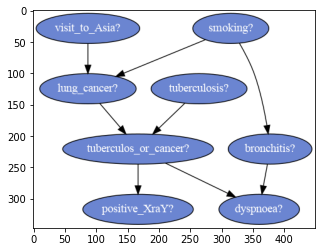

In [13]:
display_BN ( names, bn_struct, "asia", style )

## 8. Fin de l'apprentissage et calcul probabiliste (Partie optionnelle)

Comme pr√©cis√© au d√©but du TME, apprendre un r√©seau bay√©sien consiste √† d√©terminer sa structure graphique et estimer ses param√®tres. Vous avez r√©alis√© la premi√®re partie. La deuxi√®me, plus simple, peut se faire par maximum de vraisemblance pour chaque table de probabilit√© des noeuds conditionnellement √† leurs parents, comme dans le TME 3\. Utilisez la fonction **learn_parameters** ci-dessous pour effectuer cette t√¢che. Cette fonction prend en param√®tres la structure graphique que vous avez apprise ainsi que le nom du fichier CSV que vous avez utilis√© pour votre apprentissage. Elle renvoie un r√©seau bay√©sien √† la [aGrUM](http://agrum.org). Pour pouvoir utiliser aGrUM, reportez-vous √† la [question 7 du TME 2].


In [14]:
import pyAgrum as gum
import pyAgrum.lib.ipython as gnb


def learn_parameters ( bn_struct, ficname ):
    # cr√©ation du dag correspondant au bn_struct
    graphe = gum.DAG ()
    nodes = [ graphe.addNode () for i in range ( bn_struct.shape[0] ) ]
    for i in range ( bn_struct.shape[0] ):
        for parent in bn_struct[i]:
            graphe.addArc ( nodes[parent], nodes[i] )

    # appel au BNLearner pour apprendre les param√®tres
    learner = gum.BNLearner ( ficname )
    learner.useScoreLog2Likelihood ()
    learner.useAprioriSmoothing ()
    return learner.learnParameters ( graphe )


Vous pouvez maintenant r√©aliser des calculs probabilistes :

- affichage de la taille du r√©seau bay√©sien

```python
# cr√©ation du r√©seau bay√©sien √† la aGrUM
bn = learn_parameters ( bn_struct, ficname )

# affichage de sa taille
print(bn)
```

- affichage de la table de probabilit√© conditionnelle d'un noeud du r√©seau d√©termin√© par son nom (1√®re ligne du CSV):

```python

# r√©cup√©ration de la ''conditional probability table'' (CPT) et affichage de cette table
gnb.showPotential( bn.cpt ( bn.idFromName ( 'bronchitis?' ) ) )
```

- calcul de la probabilit√© marginale d'un noeud : P('bronchitis?'):


```python

# calcul de la marginale
proba = gum.getPosterior ( bn, {}, 'bronchitis?' )

```

- affichage graphique d'une distribution de probabilit√© marginale

```python
# affichage de la marginale
gnb.showPotential( proba )

```
- calcul d'une distribution marginale a posteriori : P(bronchitis? | smoking? = true, turberculosis? = false )
```python
gnb.showPotential(gum.getPosterior ( bn,{'smoking?': 'true', 'tuberculosis?' : 'false' }, 'bronchitis?' ))
```

In [15]:
ficname = 'tme5_asia.csv'
# cr√©ation du r√©seau bay√©sien √† la aGrUM
bn = learn_parameters ( bn_struct, ficname )

# affichage de sa taille
print(bn)
# r√©cup√©ration de la ''conditional probability table'' (CPT) et affichage de cette table
gnb.showPotential( bn.cpt ( bn.idFromName ( 'bronchitis?' ) ) )

# calcul de la marginale
proba = gum.getPosterior ( bn, {}, 'bronchitis?' )
gnb.showPotential( proba )
gnb.showPotential(gum.getPosterior ( bn,{'smoking?': 'true', 'tuberculosis?' : 'false' }, 'bronchitis?' ))

BN{nodes: 8, arcs: 8, domainSize: 256, dim: 38}

      ||  bronchitis?      |
smokin||false    |true     |
------||---------|---------|
false || 0.6181  | 0.3819  |
true  || 0.2917  | 0.7083  |


  bronchitis?      |
false    |true     |
---------|---------|
 0.4551  | 0.5449  |


  bronchitis?      |
false    |true     |
---------|---------|
 0.2917  | 0.7083  |



/tmp/ipykernel_4334/643824594.py:16: DeprecationWarning: 
** pyAgrum.BNLearner.useAprioriSmoothing() is deprecated from pyAgrum>1.1.1. Please use useSmoothingPrior() methods instead.

  learner.useAprioriSmoothing ()


**On retrouve bien 8 nodes et 8 arcs comme dans le graphique g√©n√©r√© pr√©c√©dementüéâ**

## 9. (Bonus) Autres bases de donn√©es

Vous pouvez appliquer vos algorithmes sur des bases un peu plus cons√©quentes qu'asia:

|  nom de la base  |            provenance           | nombre d'evenements elementaires |
|:----------------:|:-------------------------------:|:--------------------------------:|
|       asia       |          BN repository          |                $256     $          |
|       alarm      |          BN repository          |              $10^{16}   $               |
|       adult      | UCI machine learning repository |              $10^{12}   $          |
|        car       | UCI machine learning repository |               $6912     $          |
| agaricus-lepiota | UCI machine learning repository |              $10^{16}   $        |



**Prenons la plus grande base pour voir : agaricus-lepiota X)**

**Alors c'est pas des CSV, j'ai pas envie de construire `dico` manuellement. On passe sur `alarm` et sont `.bif`**

/tmp/ipykernel_4334/1484691929.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(l)


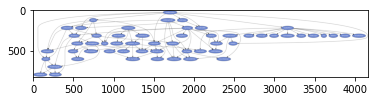

In [16]:
import pyAgrum as gum

bn = gum.loadBN('hailfinder.bif')
gum.generateSample(bn,1000, 'alarm.csv')
names, data, dico = read_csv ( "alarm.csv" )
bn_struct = learn_BN_structure ( data, dico, 0.05 )
display_BN ( names, bn_struct, "alarm", style )

In [17]:
ficname = 'alarm.csv'
# cr√©ation du r√©seau bay√©sien √† la aGrUM
bn = learn_parameters ( bn_struct, ficname )

# affichage de sa taille
print(bn)

BN{nodes: 56, arcs: 101, domainSize: 10^32.0767, dim: 3607}


/tmp/ipykernel_4334/643824594.py:16: DeprecationWarning: 
** pyAgrum.BNLearner.useAprioriSmoothing() is deprecated from pyAgrum>1.1.1. Please use useSmoothingPrior() methods instead.

  learner.useAprioriSmoothing ()
